# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.107838,True,6.173048
1,-1.242532,False,0.473366
2,-1.901565,False,-0.528143
3,0.136764,False,0.022212
4,-1.563430,False,1.719192
...,...,...,...
995,0.267111,True,5.469526
996,1.690103,True,4.306646
997,-0.053792,False,-0.471962
998,-0.645632,False,-0.325614


<Axes: xlabel='v0'>

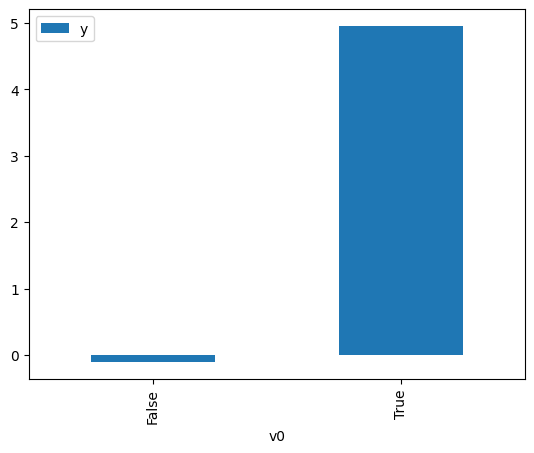

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

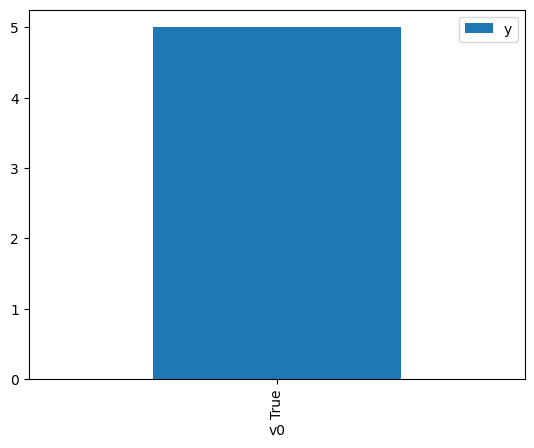

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.210209,False,-0.688049,0.943599,1.059773
1,-0.660733,False,0.242797,0.824338,1.213095
2,-0.305779,False,1.141992,0.673673,1.484400
3,0.196347,False,-0.106913,0.392503,2.547753
4,-0.573210,False,-0.844551,0.793071,1.260922
...,...,...,...,...,...
995,-0.672303,False,0.324600,0.828180,1.207467
996,-0.305779,False,1.141992,0.673673,1.484400
997,0.651787,False,-0.123782,0.183855,5.439073
998,-2.146604,False,-0.049438,0.993197,1.006850


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.511349,True,5.163834,0.002937,340.455051
1,0.085507,True,6.098206,0.544973,1.834953
2,-2.511349,True,5.163834,0.002937,340.455051
3,0.436162,True,4.648986,0.729405,1.370980
4,0.699987,True,6.136382,0.832291,1.201502
...,...,...,...,...,...
995,-2.206249,True,4.769525,0.005932,168.587307
996,-2.511349,True,5.163834,0.002937,340.455051
997,-2.206249,True,4.769525,0.005932,168.587307
998,-2.511349,True,5.163834,0.002937,340.455051


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.888
Model:                            OLS   Adj. R-squared (uncentered):              0.888
Method:                 Least Squares   F-statistic:                              3975.
Date:                Thu, 21 Dec 2023   Prob (F-statistic):                        0.00
Time:                        15:06:18   Log-Likelihood:                         -1398.7
No. Observations:                1000   AIC:                                      2801.
Df Residuals:                     998   BIC:                                      2811.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1228      0.026      4.651      0.000       0.071       0.175
x2             5.0332      0.057     87.670      0.000       4.921       5.146
==============================================================================
Omnibus:                        0.212   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.900   Jarque-Bera (JB):                0.270
Skew:                           0.030   Prob(JB):                        0.874
Kurtosis:                       2.946   Cond. No.                         2.20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""